## Libraries Used

In [ ]:
# from nltk.corpus import stopwords
# import typing
# stopcorpus: typing.List = stopwords.words('english')
# print(stopcorpus)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [199]:

# Data Handling
import pandas as pd
import numpy as np


# # Text Processing
import string
from wordcloud import STOPWORDS
import contractions
from textblob import TextBlob
from spellchecker import SpellChecker
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Display Formatting
from IPython.display import display


## Dataset extraction and organization
### Load and combine all datasets

In [200]:
# Load datasets
dataset1 = pd.read_csv('data/amazon_cells_labelled.txt', delimiter='\t', header=None, names=['Review', 'Sentiment'])
dataset2 = pd.read_csv('data/imdb_labelled.txt', delimiter='\t', header=None, names=['Review', 'Sentiment'])
dataset3 = pd.read_csv('data/yelp_labelled.txt', delimiter='\t', header=None, names=['Review', 'Sentiment'])

# Combine datasets
combined_dataset = pd.concat([dataset1, dataset2, dataset3], ignore_index=True)

# Ensure correct column ordering
combined_dataset = combined_dataset[['Review', 'Sentiment']]

# Convert Sentiment column to a centered string format 
combined_dataset["Sentiment"] = combined_dataset["Sentiment"].astype(str).apply(lambda x: f"{x:^5}")

# Display first 10 rows
display(combined_dataset.head(10)) 


,Review,Sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
5,I have to jiggle the plug to get it to line up...,0
6,If you have several dozen or several hundred c...,0
7,If you are Razr owner...you must have this!,1
8,"Needless to say, I wasted my money.",0
9,What a waste of money and time!.,0


## Data Cleaning and Preparation




In [201]:
# Load and basic cleaning
combined_dataset = combined_dataset.drop_duplicates(subset=['Review']) # Removing duplicates
print("How many null our dataset has?",combined_dataset.isnull().sum().to_string()) # Checking for missing values
combined_dataset['Review'] = combined_dataset['Review'].str.lower() # Converting to lowercase



# Tokenization (Returns List)
def tokenize_text(text):
    if isinstance(text, str):  # ensure it's a string
        blob = TextBlob(text)  # Create a TextBlob object
        return [word.lower() for word in blob.words]  # Tokenize and convert to lowercase
    return text

combined_dataset["Tokenized_Review"] = combined_dataset["Review"].apply(tokenize_text) # Apply function to dataset



# Normalize Contractions
def normalize_contractions(text):
    """Expands contractions using the contractions library."""
    return contractions.fix(text) if isinstance(text, str) else text

combined_dataset['Tokenized_Review'] = combined_dataset['Tokenized_Review'].apply(normalize_contractions) # Apply to dataset



# Remove Punctuation, Special Characters, and Numbers

# Using `.apply()` to remove punctuation from each token in the tokenized lists
combined_dataset['Tokenized_Review'] = combined_dataset['Tokenized_Review'].apply(
    lambda tokens: [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens] if isinstance(tokens, list) else tokens
)

# Removing any remaining Unicode punctuation at the token level
combined_dataset['Tokenized_Review'] = combined_dataset['Tokenized_Review'].apply(
    lambda tokens: [token for token in tokens if token.isalnum()] if isinstance(tokens, list) else tokens
)

# Removing special characters & numbers, keeping only alphabetic words
combined_dataset['Tokenized_Review'] = combined_dataset['Tokenized_Review'].apply(
    lambda tokens: [token for token in tokens if token.isalpha()] if isinstance(tokens, list) else tokens
)

# Normalizing spaces (not applicable to lists, but ensuring clean tokens)
combined_dataset['Tokenized_Review'] = combined_dataset['Tokenized_Review'].apply(
    lambda tokens: [token.strip() for token in tokens if token.strip()] if isinstance(tokens, list) else tokens
)

# Removing non-ASCII characters from each token
combined_dataset['Tokenized_Review'] = combined_dataset['Tokenized_Review'].apply(
    lambda tokens: [token.encode('ascii', 'ignore').decode('utf-8') for token in tokens] if isinstance(tokens, list) else tokens
)



# Remove Stopwords
important_words = {
    "not", "no", "never", "none", "nobody", "nothing", "neither", "nowhere",
    "isn’t", "wasn’t", "aren’t", "weren’t", "doesn’t", "didn’t", "hasn’t", 
    "hadn’t", "won’t", "wouldn’t", "can’t", "couldn’t", "shouldn’t", "mustn’t"
}

stopwords = set(STOPWORDS) - important_words
def remove_stopwords(list_tokenized):
    if isinstance(list_tokenized, list): # Ensure it's a list
        cleaned_tokenized_text = []
        for word in list_tokenized:
            if word not in stopwords:
                cleaned_tokenized_text.append(word)
        return cleaned_tokenized_text # Return cleaned sentence
    return list_tokenized

combined_dataset["Tokenized_Review"] = combined_dataset["Tokenized_Review"].apply(remove_stopwords) # Apply function to dataset



# initialize the spell checker
spell = SpellChecker()

def correct_spelling(tokens):
    if isinstance(tokens, list): # ensure it's a list of words
        corrected_tokens = [] #initialize emmpty list
        for word in tokens:
            corrected_word = spell.correction(word) # correc the word
            if corrected_word is None: # if no correction found
                corrected_word = word # use the original word
            corrected_tokens.append(corrected_word) # Append to new list
        return corrected_tokens # return the corrected list of words
    return tokens # return the original list of words

combined_dataset["Tokenized_Review"] = combined_dataset["Tokenized_Review"].apply(correct_spelling)



# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(tokens):
    if isinstance(tokens, list):
        corrected_tokens = [] 
        for word in tokens:
            corrected_word = lemmatizer.lemmatize(word)
            corrected_tokens.append(corrected_word)
        return corrected_tokens
    return tokens
            
combined_dataset['Tokenized_Review'] = combined_dataset['Tokenized_Review'].apply(lemmatize_text)



# Converting the cleaned dataset to a new dataset with a new column containing the cleaned reviews
combined_dataset['Review'] = combined_dataset['Tokenized_Review'].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else tokens)
combined_dataset['Review'].head()



How many null our dataset has? Review       0
Sentiment    0


0                    no way plug u unless go converter
1                            good case excellent value
2                                        great jawbone
3    tied charger conversation lasting minutesmajor...
4                                            mic great
Name: Review, dtype: object

## Exploratory Data Analysis
### Visualizing and analyzing sentiment distribution.

### Use bar charts 
>to show positive vs. negative sentiments.

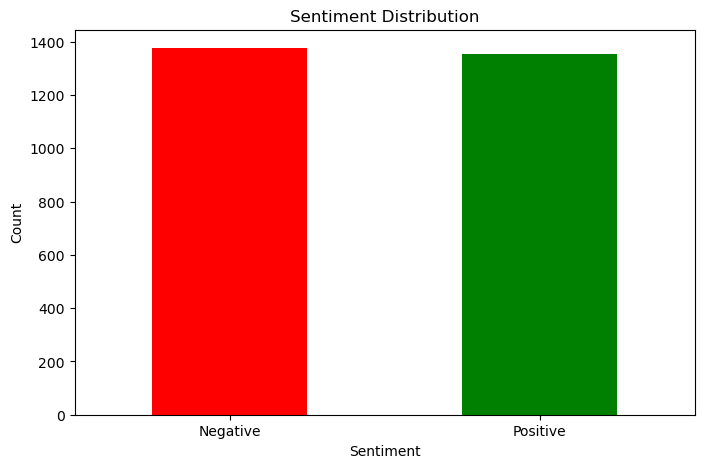

In [202]:

# Count sentiment occurrences
sentiment_counts = combined_dataset['Sentiment'].value_counts()

# Plot the sentiment distribution
sentiment_counts.plot(kind="bar", color=["red", "green"], figsize=(8,5))

# Set labels
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"], rotation=0)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")

# Show plot
plt.show()

### Distribution of review lengths
>Histogram showing text lenght distribution

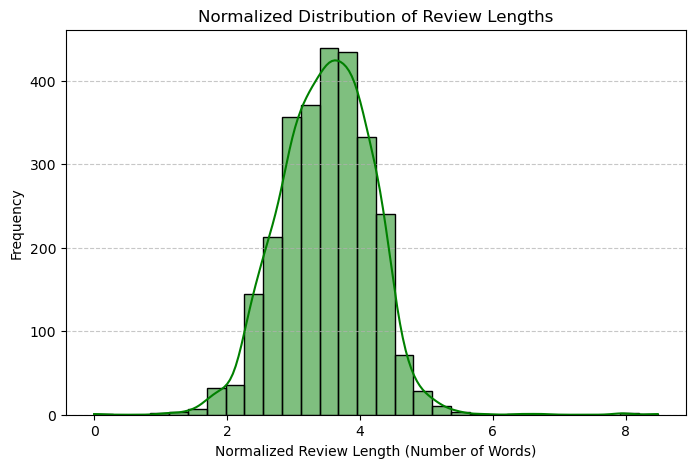

In [203]:
# Apply log transformation to normalize review length distribution
Normalized_Review_Length = np.log1p(combined_dataset["Review"].apply(len))  # log1p avoids log(0) error

# Plot histogram of log-transformed review lengths
plt.figure(figsize=(8, 5))
sns.histplot(Normalized_Review_Length, bins=30, kde=True, color="green", edgecolor="black")
plt.xlabel("Normalized Review Length (Number of Words)")
plt.ylabel("Frequency")
plt.title("Normalized Distribution of Review Lengths")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [204]:
print(combined_dataset.columns)

Index(['Review', 'Sentiment', 'Tokenized_Review'], dtype='object')


### Word Cloud for Most Frequent Word
>Generating word clouds for both positive and negative sentiments

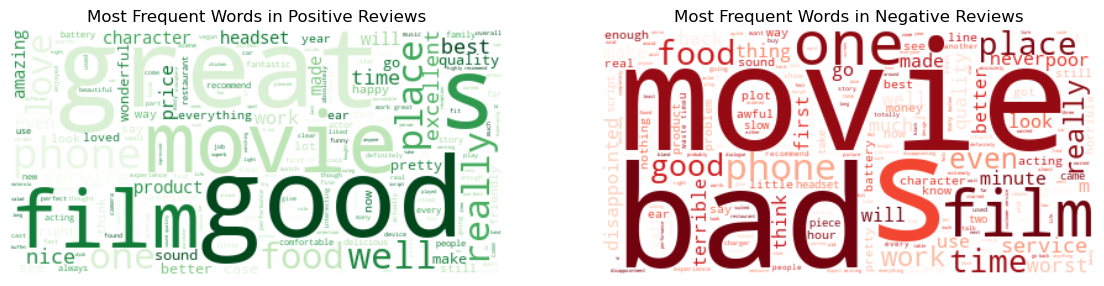

In [205]:
# Create WordCloud objects without stopwords
wc_positive = WordCloud(background_color="white", max_words=200, colormap="Greens")
wc_negative = WordCloud(background_color="white", max_words=200, colormap="Reds")

# Ensure Sentiment column is properly formatted
combined_dataset["Sentiment"] = combined_dataset["Sentiment"].astype(str).str.strip()

# Generate word clouds
positive_reviews = ' '.join(combined_dataset[combined_dataset["Sentiment"] == "1"]["Review"].tolist())  
negative_reviews = ' '.join(combined_dataset[combined_dataset["Sentiment"] == "0"]["Review"].tolist())  

positive_wc = wc_positive.generate(positive_reviews)
negative_wc = wc_negative.generate(negative_reviews)

# Plot word clouds
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Positive Reviews")

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Negative Reviews")

plt.show()


### Term Frequency Analysis
>Identifing most common words in positive and negative reviews.

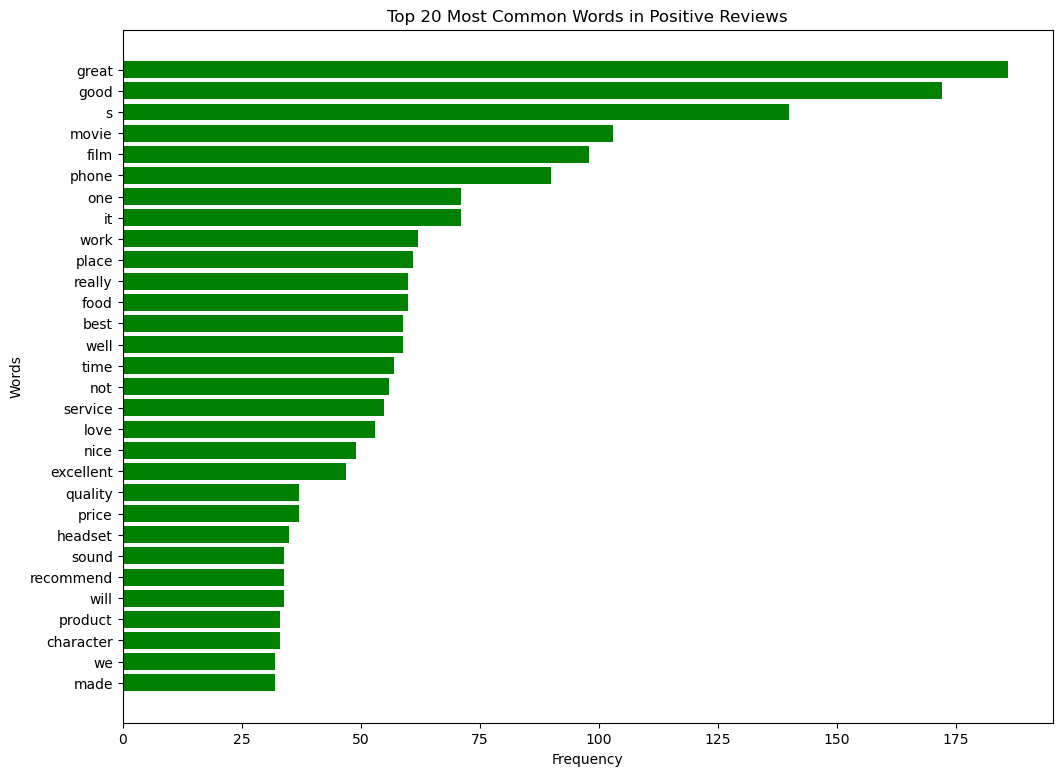

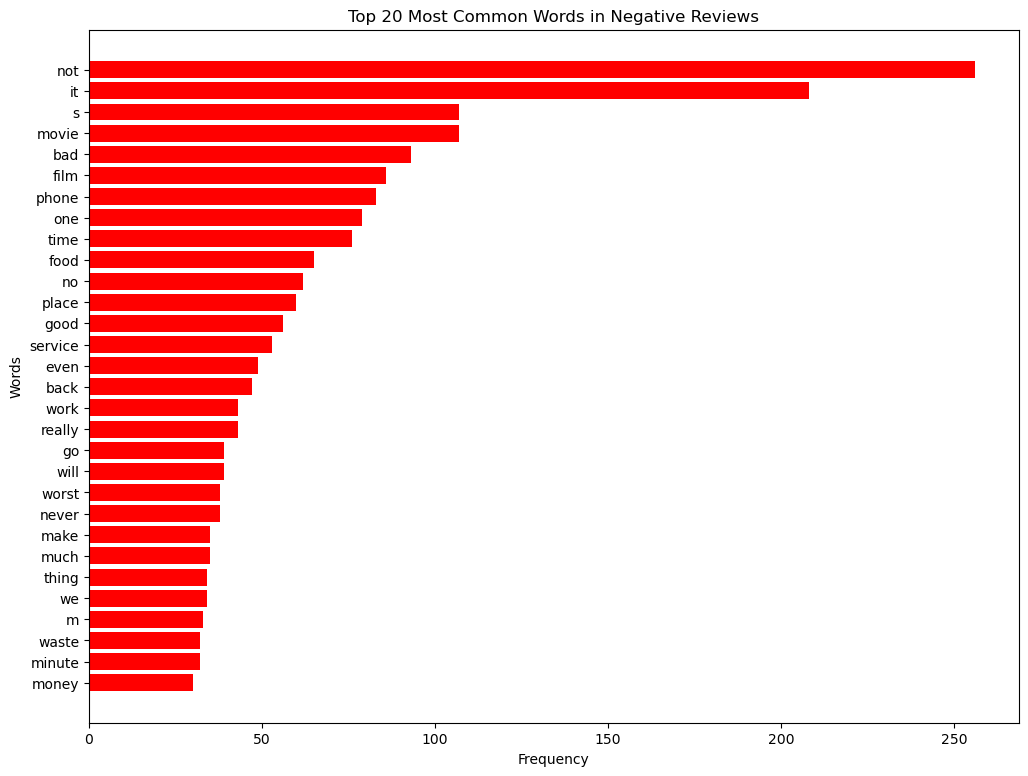

In [206]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter # import Counter to count word frequencies

combined_dataset['Review'] = combined_dataset['Review']

# Tokenize words from positive and negative reviews 
positive_words = ' '.join(combined_dataset[combined_dataset['Sentiment'].str.strip() == '1']['Review']).split() # get postive reviews from dataset using the 1 indicator
negative_words = ' '.join(combined_dataset[combined_dataset['Sentiment'].str.strip() == '0']['Review']).split() # get negative reviews from dataset using the 0 indicator


positive_word_freq = Counter(positive_words) # count positive words
negative_word_freq = Counter(negative_words) # count negative words
top_positive_words = positive_word_freq.most_common(30) # get the top 30 most used words in positive reviews
top_negative_words = negative_word_freq.most_common(30) # get the top 30 most used words in negative reviews

df_positive = pd.DataFrame(top_positive_words, columns=['Word', 'Frequency']) # DF for positive words
df_negative = pd.DataFrame(top_negative_words, columns=['Word', 'Frequency']) # DF for negative words

# plotting
plt.figure(figsize=(12, 9))
plt.barh(df_positive['Word'], df_positive['Frequency'], color='green')
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Common Words in Positive Reviews")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(12, 9))
plt.barh(df_negative['Word'], df_negative['Frequency'], color='red')
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Common Words in Negative Reviews")
plt.gca().invert_yaxis()
plt.show()

## Model Selection


 ### Vader
 >Leveraging a rule-based model to assess sentiment.

#### Vader implementation

In [207]:

# # Convert sentiment to categorical labels (0 = Negative, 1 = Positive)
combined_dataset['Sentiment'] = combined_dataset['Sentiment'].astype(int)

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply VADER to each review and get compound score
combined_dataset['VADER_compound'] = combined_dataset['Review'].apply(lambda review: analyzer.polarity_scores(review)['compound']) #  or Review 

# Convert VADER scores into binary sentiment labels
combined_dataset["VADER_Prediction"] = combined_dataset["VADER_compound"].apply(lambda score: 1 if score >= 0.05 else 0)


# Test with a Custom Sentence
def predict_sentiment_vader(text):
    score = analyzer.polarity_scores(text)['compound']
    sentiment = "Positive" if score >= 0.05 else "Negative"
    return sentiment, score

dummy_reviews= [
    "This product is really cool",
    "This movie sucked",
    "I hate this",
    "Had a really good time",
    "My son and I thought it was just okay",
    "Where can I see more of this?"
]

for review in dummy_reviews:
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {predict_sentiment_vader(review)[0]}")
    print(f"Sentiment Score: {predict_sentiment_vader(review)[1]:.2f}\n")


Review: This product is really cool
Predicted Sentiment: Positive
Sentiment Score: 0.38

Review: This movie sucked
Predicted Sentiment: Negative
Sentiment Score: -0.46

Review: I hate this
Predicted Sentiment: Negative
Sentiment Score: -0.57

Review: Had a really good time
Predicted Sentiment: Positive
Sentiment Score: 0.49

Review: My son and I thought it was just okay
Predicted Sentiment: Positive
Sentiment Score: 0.23

Review: Where can I see more of this?
Predicted Sentiment: Negative
Sentiment Score: 0.00



#### Testing Vader Model

### Logisitic Regression 
>Training a supervised learning model for sentiment classification

In [208]:
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS) 

def remove_stopwords(text): # function to remove stopwords from dataset 
    return ' '.join(word for word in text.split() if word not in stopwords)

combined_dataset['Review'] = combined_dataset['Review'] # apply removal function


vectorizer = TfidfVectorizer(max_features=10000) # keep top 10k words
x = vectorizer.fit_transform(combined_dataset['Review']) # create TF-IDF matrix
y = combined_dataset['Sentiment'] # target variable
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) # splitting data so we can train model 


model = LogisticRegression() # initialize
model.fit(x_train, y_train) # train model
y_pred = model.predict(x_test) # predict on our data
accuracy = accuracy_score(y_test, y_pred) # calculate accuracy
accuracy = accuracy*100 # convert to percentage
print(f"Accuracy: {accuracy:.2f}%")


def predict_sentiment(text): # creating function to predict sentiment (0 = negative, 1 = positive) on some dummy data
    vectorized_text = vectorizer.transform([text])
    sentiment = model.predict(vectorized_text)[0]
    return sentiment

def sentiment_score(text): # creating function to see exactly how positive or negative a review is
    vectorized_text = vectorizer.transform([text])
    sentiment_score = model.decision_function(vectorized_text)[0]
    return sentiment_score

dummy_reviews= [
    "This product is really cool",
    "This movie sucked",
    "I hate this",
    "Had a really good time",
    "My son and I thought it was just okay",
    "Where can I see more of this?"
]

for review in dummy_reviews:
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {predict_sentiment(review)}")
    print(f"Sentiment Score: {sentiment_score(review):.2f}\n")


Accuracy: 79.52%
Review: This product is really cool
Predicted Sentiment: 1
Sentiment Score: 1.05

Review: This movie sucked
Predicted Sentiment: 0
Sentiment Score: -0.45

Review: I hate this
Predicted Sentiment: 0
Sentiment Score: -0.92

Review: Had a really good time
Predicted Sentiment: 1
Sentiment Score: 1.91

Review: My son and I thought it was just okay
Predicted Sentiment: 0
Sentiment Score: -0.54

Review: Where can I see more of this?
Predicted Sentiment: 1
Sentiment Score: 0.14



### VADER  

### plot confusion matrix

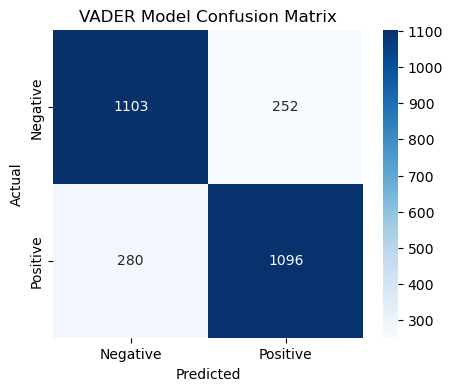

In [209]:
# plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(combined_dataset['Sentiment'], combined_dataset["VADER_Prediction"]), annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("VADER Model Confusion Matrix")
plt.show()


## Model Analysis 


### Threshold-Based Accuracy
>Measures how often VADER’s sentiment matches labels.

In [210]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score

#  Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

#  Apply VADER to each review and get the compound score
combined_dataset['VADER_Compound'] = combined_dataset['Review'].apply(lambda review: analyzer.polarity_scores(review)['compound'])

#  Convert VADER scores into binary sentiment labels (Threshold-Based)
combined_dataset["VADER_Prediction"] = combined_dataset["VADER_Compound"].apply(lambda score: 1 if score >= 0.05 else 0)

#  Compute Threshold-Based Accuracy
accuracy = accuracy_score(combined_dataset['Sentiment'], combined_dataset['VADER_Prediction'])

#  Print Accuracy Result
print(f"VADER Threshold-Based Accuracy: {accuracy:.2%}")


VADER Threshold-Based Accuracy: 80.52%


#### Mean Squared Error (MSE) 
>Measures how close VADER's scores are to actual sentiment.

In [211]:
import numpy as np

# Compute MSE manually using NumPy
mse = np.mean((combined_dataset['Sentiment'] - combined_dataset['VADER_Compound']) ** 2)

print(f"VADER Mean Squared Error (MSE): {mse:.4f}")


VADER Mean Squared Error (MSE): 0.2874


#### Spearman/Pearson Correlation 
>Measures how well VADER scores align with actual sentiment.


In [212]:
# Pearson correlation (linear relationship)
pearson_corr = combined_dataset['Sentiment'].corr(combined_dataset['VADER_Compound'], method='pearson')

# Spearman correlation (rank-based, monotonic relationship)
spearman_corr = combined_dataset['Sentiment'].corr(combined_dataset['VADER_Compound'], method='spearman')

print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")


Pearson Correlation: 0.6651
Spearman Correlation: 0.6675


### Logistic Regression

#### Confusion Matrix
>Essential for analyzing false positives and false negatives.

#### ROC Curve & AUC
>Measures classification performance across thresholds.

### Vader vs Logistic Regression Results

## Conclusion